# Natural language inference

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2016 term"

## Contents

0. [Overview](#Overview)
0. [Set-up](#Set-up)
0. [Working with SNLI](#Working-with-SNLI)
   0. [Trees](#Trees)
   0. [Readers](#Readers)
0. [MaxEnt classifier approach](#MaxEnt-classifier-approach)
   0. [Baseline classifier features](#Baseline-classifier-features)
   0. [Building datasets for experiments](#Building-datasets-for-experiments)
   0. [Training](#Training)
   0. [Running experiments](#Running-experiments)
0. [Recurrent neural network approach](#Recurrent-neural-network-approach)
0. [Additional NLI resources](#Additional-NLI-resources)
0. [Homework 4](#Homework-4)

## Overview

In the context of NLP/NLU, Natural Language Inference (NLI) is the task of predicting the logical relationships between words, phrases, sentences, (paragraphs, documents, ...). Such relationships are crucial for all kinds of reasoning in natural language: arguing, debating, problem solving, summarization, extrapolation, and so forth. 

NLI is a great task for this course. It requires serious linguistic analysis to do well, there are good publicly available datasets, and there are some natural baselines that help with getting a model up and running, and with understanding the performance of more sophisticated approaches.  NLI was also the topic of [Bill's thesis](http://nlp.stanford.edu/~wcmac/papers/nli-diss.pdf) (he popularized the name "NLI"), so you can forever endear yourself to him by working on it!

We looked at NLI briefly in our word-level entailment bake-off (the `wordentail.ipynb` notebook). The purpose of this codebook is to introduce the problem of NLI more fully in the context of the [Stanford Natural Language Inference](http://nlp.stanford.edu/projects/snli/) corpus (SNLI). We'll explore two general approaches:

* Standard classifiers
* Recurrent neural networks

This should be a good starting point for exploring richer models of NLI.

In [2]:
import os
import re
import sys
import pickle
import numpy as np
import itertools
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import utils
from nltk.tree import Tree
from nli_rnn import ClassifierRNN

## Set-up

0. Make sure your environment includes all the requirements for [the cs224u repository](https://github.com/cgpotts/cs224u), especially TensorFlow, which isn't included in the standard Anaconda distribution (but is [easily installed](https://anaconda.org/jjhelmus/tensorflow)).
0. Make sure `snli_sample_src` is pointing to your copy of `semparse_dateparse_data.pickle`, which should be included in the repository in the `nli-data` subfolder. (Because SNLI is very large, we'll work with a small sample from the training set in class.)
0. For the homework: make sure you've run `nltk.download()` to get the NLTK data. (In particular, you need to use NLTL's WordNet API.)

In [3]:
# Home for our SNLI sample:
snli_sample_src = os.path.join('nli-data', 'snli_1.0_cs224u_sample.pickle')

# Load the dataset: a dict with keys `train`, `dev`, and `vocab`. The first
# two are lists of `dict`s sampled from the SNLI JSONL files. The third is
# the complete vocabulary of the leaves in the trees for `train` and `dev`.
snli_sample = pickle.load(open(snli_sample_src, 'rb'))

snli_sample.keys()

dict_keys(['train', 'vocab', 'dev'])

## Working with SNLI

SNLI contains both regular string representations of the data and unlabeled binary parses like the following:

`
entailment  ( ( A child ) ( is ( playing ( in ( a yard ) ) ) ) )  ( ( A child ) ( is playing ) )
`

`
neutral  ( ( A child ) ( is ( playing ( in ( a yard ) ) ) ) )  ( ( A child ) ( is ( wearing ( blue jeans ) ) ) )
`

`
contradiction  ( ( A child ) ( is ( playing ) ) )  ( ( A child ) ( is sleeping ) )
`

The brackets encode a label-free constituency structure of each sentence. The three labels on the left  are the classes that we want to learn to predict. We'll frequently need access to them, so let's define
them as a list:

In [4]:
LABELS = ['contradiction', 'entailment', 'neutral']

The training set for SNLI contains 550,152 sentence pairs, with sentences varying in length from 2 to 62 words. This is too large for in-class experiments. This is why we're working with the sample in `snli_sample`:

* `snli_sample['train']`: 12K sentence pairs
* `snli_sample['test']`: 3K sentence pairs

Both parts are balanced across the three classes, with sentences varying in length from 4 to 6 words. These limitations will allow us to explore lots of different models in class. You're encouraged to try out your ideas on the full dataset outside of class (perhaps as part of your final project).

### Trees

The following function can be used to turn bracketed strings like the above into tuples of tuples encoding the syntactic structure:

In [5]:
def str2tree(s):
    """Map str s to an nltk.tree.Tree instance. The assumption is that 
    s represents a tree with no node labels. We add a nonce label 'X'
    for compatability with `Tree.fromstring`."""
    s = s.replace("(", "(X")
    return Tree.fromstring(s)    

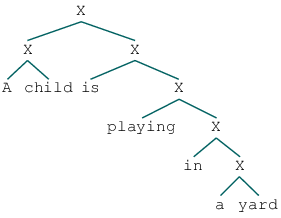

In [6]:
t = str2tree("( ( A child ) ( is ( playing ( in ( a yard ) ) ) ) )")
t

For baseline models, we often want just the words, also called terminal nodes or _leaves_. We can access them with the `leaves` method on `nltk.tree.Tree` instances:

In [7]:
t.leaves()

['A', 'child', 'is', 'playing', 'in', 'a', 'yard']

### Readers

To make it easy to run through the corpus, let's define general readers for the data. The general function for this yields triples consisting of the the left tree and the right tree, as parsed by `str2tree`, and finally the label:

In [8]:
def snli_reader(sample):
    """Reader for SNLI data. `sample` just needs to be an iterator over
    the SNLI JSONL files. For this notebook, it will always be 
    `snli_sample`, but, for example, the following should work for the 
    corpus files:
    
    import json    
    def sample(src_filename):
        for line in open(src_filename):
            yield json.loads(line)
    
    Yields
    ------
    tuple
        (tree1, tree1, label), where the trees are from `str2tree` and
        label is in `LABELS` above.
      
    """
    for d in sample:
        yield (str2tree(d['sentence1_binary_parse']), 
               str2tree(d['sentence2_binary_parse']),
               d['gold_label'])
        
def train_reader():
    """Convenience function for reading just the training data."""
    return snli_reader(snli_sample['train'])

def dev_reader():
    """Convenience function for reading just the dev data."""
    return snli_reader(snli_sample['dev'])

## MaxEnt classifier approach

To start, we'll adopt an approach that is essentially identical to that of the [supervisedsentiment.ipynb](supervisedsentiment.ipynb) notebook: we'll train simple MaxEnt classifiers on representations of the data obtained from hand-built feature functions. 

This notebook defines some common baseline features based on pairings of information in the premise and hypothesis. As usual, one can realize big performance gains quickly by improving on these baseline representations.

### Baseline classifier features

The first baseline we define is the _word overlap_ baseline. It simply uses as
features the words that appear in both sentences.

In [9]:
def word_overlap_phi(t1, t2):    
    """Basis for features for the words in both the premise and hypothesis.
    This tends to produce very sparse representations.
    
    Parameters
    ----------
    t1, t2 : tuples
        Tuples of tuples representing strings, as given by `str2tree`.
        
    Returns
    -------
    defaultdict
       Maps each word in both `t1` and `t2` to 1.
    
    """
    overlap = set([w1 for w1 in t1.leaves() if w1 in t2.leaves()])
    return Counter(overlap)

Another popular baseline is to use as features the full cross-product of
words from both sentences:    

In [10]:
def word_cross_product_phi(t1, t2):
    """Basis for cross-product features. This tends to produce pretty 
    dense representations.
    
    Parameters
    ----------
    t1, t2 : tuples
        Tuples of tuples representing strings, as given by `str2tree`.
        
    Returns
    -------
    defaultdict
        Maps each (w1, w2) in the cross-product of `leaves(t1)` and 
        `leaves(t2)` to its count. This is a mult-set cross-product
        (repeats matter).
    
    """
    return Counter([(w1, w2) for w1, w2 in itertools.product(leaves(t1), leaves(t2))])

Both of these feature functions return count dictionaries mapping feature names to  the number of times they occur in the data. This is the representation we'll work with throughout; `sklearn` will handle the further processing it needs to build linear classifiers.

Naturally, you can do better than these feature functions! Both of these feature classes might be useful even in a more advanced model, though.

### Building datasets for experiments

As usual, the first step in training a classifier is using a feature function like the one above to turn the data into a list of training instances (feature representations and their associated labels):

In [11]:
def build_dataset(reader, phi=word_overlap_phi, vectorizer=None):
    """Create a dataset for training classifiers using `sklearn`.
    
    Parameters
    ----------
    reader
        An SNLI iterator like `snli_reader` above. Just needs to
        yield (tree, tree, label) triples.
        
    phi : featuer function
        Maps trees to count dictionaries.
        
    vectorizer : sklearn.feature_extraction.DictVectorizer    
        If this is None, then a new `DictVectorizer` is created and
        used to turn the list of dicts created by `phi` into a 
        feature matrix. This happens when we are training.
              
        If this is not None, then it's assumed to be a `DictVectorizer` 
        and used to transform the list of dicts. This happens in 
        assessment, when we take in new instances and need to 
        featurize them as we did in training.
        
    Returns
    -------
    dict
        A dict with keys 'X' (the feature matrix), 'y' (the list of
        labels), 'vectorizer' (the `DictVectorizer`), and 
        'raw_examples' (the original tree pairs, for error analysis).
    
    """
    feat_dicts = []
    labels = []
    raw_examples = []
    for t1, t2, label in reader():
        d = phi(t1, t2)
        feat_dicts.append(d)
        labels.append(label)   
        raw_examples.append((t1, t2))
    if vectorizer == None:
        vectorizer = DictVectorizer(sparse=True)
        feat_matrix = vectorizer.fit_transform(feat_dicts)
    else:
        feat_matrix = vectorizer.transform(feat_dicts)
    return {'X': feat_matrix, 
            'y': labels, 
            'vectorizer': vectorizer, 
            'raw_examples': raw_examples}

### Training

To keep this notebook relatively simple, we adopt a bare-bones training framework, using just a standard-issue MaxEnt classifier. The following function is from [supervisedsentiment.ipynb](supervisedsentiment.ipynb):

In [12]:
def fit_maxent_classifier(X, y):    
    """Wrapper for `sklearn.linear.model.LogisticRegression`. This is also 
    called a Maximum Entropy (MaxEnt) Classifier, which is more fitting 
    for the multiclass case.
    
    Parameters
    ----------
    X : 2d np.array
        The matrix of features, one example per row.
        
    y : list
        The list of labels for rows in `X`.
    
    Returns
    -------
    sklearn.linear.model.LogisticRegression
        A trained `LogisticRegression` instance.
    
    """
    mod = LogisticRegression(fit_intercept=True)
    mod.fit(X, y)
    return mod

For a more robust and responsible approach, see [supervisedsentiment.ipynb](supervisedsentiment.ipynb) notebook, especially the [section on hyperparameter search](supervisedsentiment.ipynb#Hyperparameter-search). The [first homework problem below](#Homework-4) pushes you a bit in this direction.

### Running experiments

The `experiment` function handles the book-keeping associated with running experiments. It essentially just combines all of the above pieces in a flexible way. If you decide to expand this codebase for real experiments, then you'll likely want to incorporate more of the functionality from the [supervisedsentiment.ipynb](supervisedsentiment.ipynb) notebook, especially [its method for comparing different models statistically](supervisedsentiment.ipynb#Statistical-comparison-of-classifier-models).

In [13]:
def experiment(
        train_reader=train_reader, 
        assess_reader=dev_reader, 
        phi=word_overlap_phi,
        train_func=fit_maxent_classifier):  
    """Runs experiments on our SNLI fragment.
    
    Parameters
    ----------
    train_reader, assess_reader
        SNLI iterators like `snli_reader` above. Just needs to
        yield (tree, tree, label) triples.
        
    phi : feature function (default: `word_overlap_phi`)
        Maps trees to count dictionaries.
        
    train_func : model wrapper (default: `fit_maxent_classifier`)
        Any function that takes a feature matrix and a label list
        as its values and returns a fitted model with a `predict`
        function that operates on feature matrices.
    
    Returns
    -------
    str
         A formatted `classification_report` from `sklearn`.
        
    """
    train = build_dataset(train_reader, phi)    
    assess = build_dataset(assess_reader, phi, vectorizer=train['vectorizer'])
    mod = fit_maxent_classifier(train['X'], train['y'])
    predictions = mod.predict(assess['X'])
    return classification_report(assess['y'], predictions)

In [14]:
print(experiment())

             precision    recall  f1-score   support

contradiction       0.36      0.45      0.40       100
 entailment       0.41      0.32      0.36       100
    neutral       0.36      0.34      0.35       100

avg / total       0.37      0.37      0.37       300



### A few ideas for better classifier features

* Cross product of synsets compatible with each word, as given by WordNet. (Here is [a codebook on using WordNet from NLTK to do things like this](http://compprag.christopherpotts.net/wordnet.html).)

* More fine-grained WordNet features &mdash; e.g., spotting pairs like _puppy_/_dog_ across the two sentences.

* Use of other WordNet relations (see Table 1 and Table 2 in [this codelab](http://compprag.christopherpotts.net/wordnet.html) for relations and their coverage).

* Using the tree structure to define features that are sensitive to how negation scopes over constituents.

* Features that are sensitive to differences in negation between the two sentences.

* Sentiment features seeking to identify contrasting polarity.

## Recurrent neural network approach

In [27]:
def build_rnn_dataset(reader):
    dataset = []
    for (t1, t2, label) in reader():
        seq = t1.leaves() + t2.leaves()
        y_ = np.zeros(3)
        y_[LABELS.index(label)] = 1.0
        dataset.append((seq, y_))
    return dataset

In [28]:
def rnn_experiment(word_dim, hidden_dim, maxiter=10):    
    vocab = snli_sample['vocab']
    embedding = np.array([utils.randvec(word_dim) for w in vocab])
    
    train = build_rnn_dataset(train_reader)       
    mod = nli_rnn.ClassifierRNN(
        vocab, 
        embedding, 
        hidden_dim=hidden_dim, 
        maxiter=maxiter)
    mod.fit(train)
    
    assess = build_rnn_dataset(dev_reader) 
    for seq, y_ in assess:
        gold.append(LABELS[np.argmax(y_)])
        p = mod.predict(seq)
        predictions.append(LABELS[p])

    return classification_report(gold, predictions)

In [30]:
print(rnn_experiment(word_dim=10, hidden_dim=10, maxiter=10))

Finished epoch 10 of 10; error is 1.1030656785

             precision    recall  f1-score   support

contradiction       0.34      0.49      0.40      1200
 entailment       0.34      0.26      0.30      1200
    neutral       0.37      0.28      0.32      1200

avg / total       0.35      0.34      0.34      3600



## Additional NLI resources

* The folder [nli-data](nli-data) in this repository contains the NLI data from the [SemEval 2014 semantic relatedness task](http://alt.qcri.org/semeval2014/task1/). 
This data set is called "Sentences Involving Compositional Knowledge" or, for better or worse, 
"SICK". It's [freely available from the SemEval site](http://alt.qcri.org/semeval2014/task1/index.php?id=data-and-tools).  [nli-data](nli-data) contains a parsed version created by [Sam Bowman](http://stanford.edu/~sbowman/) 
as part of [his research on neural models of semantic composition](https://github.com/sleepinyourhat/vector-entailment/releases/tag/W15-R1). 

* [SemEval 2013](https://www.cs.york.ac.uk/semeval-2013/) also had a wide range of interesting data sets for NLI and related tasks.

* The [FraCaS textual inference test suite](http://www-nlp.stanford.edu/~wcmac/downloads/) is a smaller, hand-built dataset that is great for evaluating a model's ability to handle complex logical patterns.

* Models for NLI might be adapted for use with the [30M Factoid Question-Answer Corpus](http://agarciaduran.org).

* Models for NLI might be adapted for use with the [Penn Paraphrase Database](http://paraphrase.org).

## Homework 4

### 1. Feature selection [2 points]

Create a modification of `fit_maxent_classifier` called `fit_maxent_classifier_with_feature_selection` that does feature selection prior to fitting the model using  [sklearn.feature_selection.SelectPercentile](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectPercentile) with [sklearn.feature_selection.chi2](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2) as `score_func`. You can leave the default `percentile=10`. __Submit__:

* Your `fit_maxent_classifier_with_feature_selection`.
* Your use of `experiment` with `fit_maxent_classifier_with_feature_selection`.
* Your output from the `experiment` function call.

### 2. WordNet-based entailment features [4 points]

[Python NLTK](http://www.nltk.org) has an excellent WordNet interface. As noted above, WordNet is a natural choice for defining useful features in the context of NLI.

__Your task__: write and submit a feature function, for use with `build_dataset`, that is just like `word_cross_product_phi` except that, given a sentence pair $(S_{1}, S_{2})$, it counts only pairs $(w_{1}, w_{2})$ such that $w_{1}$ entails $w_{2}$, for $w_{1} \in S_{1}$ and $w_{2} \in S_{2}$. For example, the sentence pair (_the cat runs_, _the animal moves_) would create the dictionary `{(cat, animal): 1.0, (runs, moves): 1.0}`.

There are many ways to do this. For the purposes of the question, we can limit attention to the WordNet hypernym relation. The following illustrates reasonable ways to go from a string $s$ to the set of all hypernyms of Synsets consistent with $s$:

In [ ]:
from nltk.corpus import wordnet as wn
    
puppies = wn.synsets('puppy')
print [h for ss in puppies for h in ss.hypernyms()]

# A more conservative approach uses just the first-listed 
# Synset, which should be the most frequent sense:
print wn.synsets('puppy')[0].hypernyms()

### 3. RNN [4 points]

